In [1]:
# Importing libraries
from copy import deepcopy
import random


# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 
from sympy import var, plot_implicit

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error # Calculate the accuracy

# Loading Bar
from time import sleep
from tqdm import tqdm

# Convex Hull
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet
import scipy.stats as sts
from scipy.spatial.distance import euclidean
from scipy import stats as st
from scipy.optimize import fmin_tnc

# Supress warnings
import warnings; warnings.simplefilter('ignore')

In [2]:
# Loading Dataset
adult_folder = pd.read_csv('adult.csv') # Loading Adult

In [3]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [6]:
adult_dataset = Adult_Data_Clean(adult_folder)

# Separating label (income) from the rest of the data and making income binary
income_raw = adult_dataset['income'].tolist()
adult_dataset = adult_dataset.drop(['income'], axis=1)
income = pd.Series(income_raw).astype('category').cat.codes.tolist()
adult_dataset.drop(adult_dataset.columns.difference(['age', 'educational-num', 'gender', 'loss', 'hours']), 1, inplace=True)
income = 2*np.array(income) - 1

In [7]:
# One-Hot encoding
per_adult_encoded = pd.get_dummies(adult_dataset)

In [8]:
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_adult_encoded, income, test_size = 0.5, random_state = 0)

In [9]:
def test(model, qtd_data):
    #Predicting
    y_test_pred = model.predict(X_test[0:qtd_data])
    #y_train_pred = model.predict(X_train)

    # Getting accuracy for the personalized classifier
    #per_train_acc = accuracy_score(Y_train, y_train_pred)
    #per_test_acc = accuracy_score(Y_test[0:qtd_data], y_test_pred)
    
    # L2 score
    #l2_train_acc = mean_squared_error(Y_train, y_train_pred)
    l2_test_acc = mean_squared_error(Y_test[0:qtd_data], y_test_pred)
    
    return l2_test_acc

In [10]:
def multiplicity(m1, m2):
    y_test_pred_1 = m1.predict(X_test)
    y_test_pred_2 = m2.predict(X_test)
    
    return np.mean(np.abs(y_test_pred_1 - y_test_pred_2))

In [11]:
def get_theoretical_Rashomon(X_t, center, w, alpha, epsilon):
    X = X_t.to_numpy()
    Id = np.identity(X.shape[1])
    A = (X.T @ X + alpha*Id)/epsilon
    v = center - w
    a = (v @ A) @ v.T - 1
    return a

## Sampling in the Convex hull

In [12]:
# Sampling from Rashomon set

def samp_in_hull(deln, n):
    dims = points.shape[-1] #get dim
    hull = points[ConvexHull(points).vertices] #get hull
    deln = hull[Delaunay(hull).simplices] #get Delunay

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum()) 

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

## Implementing Ridge

In [13]:
def get_ridge(X, Y, alpha):
    return np.linalg.inv(X.T@X + alpha*np.identity(X.shape[1])) @ X.T @ Y

def get_ridge_prediction(parameter, X):
    return X@parameter

def get_ridge_l2_loss(parameter, alpha, X, Y):
    fp = Y - X@parameter
    n = X.shape[0]
    return (np.dot(fp, fp) + alpha * np.dot(parameter, parameter) )

## Calculating the Rashomon set

In [14]:
alpha = 1
np_X = X_train.to_numpy()
omega_hat = get_ridge(np_X, Y_train, alpha)
np_X_test = X_test.to_numpy()

pred = get_ridge_prediction(omega_hat, np_X)
pred_test = get_ridge_prediction(omega_hat, np_X_test)
#np.mean(get_thresholded(pred) == Y_train), np.mean(get_thresholded(pred_test) == Y_test)

In [15]:
center = omega_hat
delta = 0.1 #Size of initial noise
step = 0.0001 #step size for each step in an direction
samples = 1000 #number of directions
qtd_points = X_train.shape[0]
epsilon = 0.1 * get_ridge_l2_loss(center, alpha, np_X, Y_train) #Rashomon set size

extremes_l = np.zeros((samples, center.size))
early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (get_ridge_l2_loss(direction, alpha, np_X, Y_train) - get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)) < epsilon:
        extremes_l[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

100%|███████████████████████████████████████| 1000/1000 [07:52<00:00,  2.12it/s]


# Generating the mode ensamble

In [16]:
def get_thresholded(pred):
    return 2*(pred > 0)*1 - 1

def get_mode_prediction(models_in_ensemble, X):
    n_models = models_in_ensemble.shape[0]
    pred = np.zeros((n_models, X.shape[0]))
    for i in range(n_models):
        pred[i] = get_thresholded(get_ridge_prediction(models_in_ensemble[i], X))  #geting votes
        
    return st.mode(pred)[0] #np.mean(pred, axis = 0) 

# Sampling from Rashomon set after calculating cvx hull and triangulation
def samp_in_hull_after(deln, vols, n):
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())
    
    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

In [17]:
dims = extremes_l.shape[-1] #get dim
hull = extremes_l[ConvexHull(extremes_l).vertices] #get hull
deln = hull[Delaunay(hull).simplices] #get Delunay
vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas


In [18]:
n = 5000 #number of models in the ensamblex

# Getting predictions for the optimal parameter
omega_hat = get_ridge(np_X, Y_train, alpha)
pred = get_ridge_prediction(omega_hat, np_X)


In [19]:
models_in_ensemble = samp_in_hull_after(deln, vols, n)
ensamble_predition = get_mode_prediction(models_in_ensemble, np_X)

In [23]:
# selecting a model at random 
random_model_pred = get_ridge_prediction( samp_in_hull_after(deln, vols, 1)[0], np_X)
random_model_t_pred = get_thresholded(random_model_pred)
print('The Ensamble and the Optimal desagree in: ' + str(np.sum(ensamble_predition != get_thresholded(pred))) + ' predictions')
print('The Ensamble and a random model desagree in: ' + str(np.sum(ensamble_predition != random_model_t_pred)) + ' predictions')
print('The Optimal and a random model desagree in: ' + str(np.sum(get_thresholded(pred) != random_model_t_pred)) + ' predictions')


The Ensamble and the Optimal desagree in: 43 predictions
The Ensamble and a random model desagree in: 787 predictions
The Optimal and a random model desagree in: 796 predictions


In [24]:
print('The accuracy of the Ensamble model is: ' + str(np.mean(ensamble_predition[0] == Y_train)))
print('The accuracy of the Optimal model is: ' + str(np.mean(get_thresholded(pred) == Y_train)))

The accuracy of the Ensamble model is: 0.7955862190968997
The accuracy of the Optimal model is: 0.7951881827429127


In [22]:
print('The test accuracy of the Ensamble model is: ' + str(np.mean(get_mode_prediction(models_in_ensemble, X_test)[0] == Y_test)))
print('The test accuracy of the Optimal model is: ' + str(np.mean(get_thresholded(get_ridge_prediction(omega_hat, X_test)) == Y_test)))


The test accuracy of the Ensamble model is: 0.7932422272345319
The test accuracy of the Optimal model is: 0.792888417142099


In [30]:
montecarlo_tries = 2000
avg_ensamble_disagreement = 0
avg_optimal_disagreement = 0
n_range= np.array([5000])
n_size = len(n_range)
acc_ensembles = np.zeros(n_size)
disagreements_difference = np.zeros(n_size)

for j in range(n_size):
    avg_ensamble_disagreement = 0
    avg_optimal_disagreement = 0
    
    models_in_ensemble = samp_in_hull_after(deln, vols, n_range[j])
    ensamble_predition = get_mode_prediction(models_in_ensemble, np_X)
    
    for i in tqdm(range(montecarlo_tries)):    
        random_model_pred = get_ridge_prediction(samp_in_hull_after(deln, vols, 1)[0], np_X)
        random_model_t_pred = get_thresholded(random_model_pred)
        
        avg_ensamble_disagreement += np.sum(ensamble_predition != random_model_t_pred)
        avg_optimal_disagreement += np.sum(get_thresholded(pred) != random_model_t_pred)
        
        #print(np.sum(ensamble_predition != random_model_t_pred) - np.sum(get_thresholded(pred) != random_model_t_pred))
    
        disagreements_difference[j] = - avg_ensamble_disagreement/montecarlo_tries + avg_optimal_disagreement/montecarlo_tries
        acc_ensembles[j] = np.mean(ensamble_predition == Y_train)


100%|███████████████████████████████████████| 2000/2000 [01:26<00:00, 23.17it/s]


In [33]:
disagreements_difference, acc_ensembles

(array([0.203]), array([0.79549777]))

## Ploting qtd. models in the ensamble vs consistency (avarage L1 dist)

Text(0.5, 1.0, 'Fairness Rashomon level trade-off')

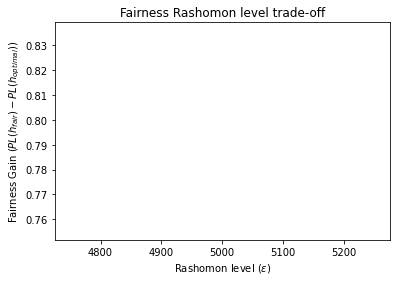

In [34]:
plt.plot(n_range, acc_ensembles, color = 'black')
# plt.xlim([0,0.2])
# plt.ylim([0, 15])
plt.xlabel(r'Rashomon level ($\epsilon$)')
plt.ylabel(r'Fairness Gain ($PL(h_{fair}) - PL(h_{optimal})$)')
plt.title('Fairness Rashomon level trade-off')


In [ ]:
plt.plot(ns, ensamble_consistances, color = 'black')
plt.plot(ns, optimal_consistances, color = 'red')
plt.show()

In [ ]:
np.mean(ensamble_consistances < optimal_consistances)

In [ ]:
plt.plot(ns, prob_consistences, color = 'black')
plt.show()

# Compas Data

In [ ]:
import pandas as pd
def load_data(name='adult'):
    #% Processing for COMPAS
    if name == 'compas':
        file = 'compas-scores-two-years.csv'
        df = pd.read_csv(file,index_col=0)
        aux = df
        
        # select features for analysis
        df = df[['age', 'c_charge_degree', 'race',  'sex', 'priors_count', 
                   'days_b_screening_arrest',  'is_recid',  'c_jail_in', 'c_jail_out', 'juv_fel_count']]
        
        # drop missing/bad features (following ProPublica's analysis)
        # ix is the index of variables we want to keep.

        # Remove entries with inconsistent arrest information.
        ix = df['days_b_screening_arrest'] <= 30
        ix = (df['days_b_screening_arrest'] >= -30) & ix

        # remove entries entries where compas case could not be found.
        ix = (df['is_recid'] != -1) & ix

        # remove traffic offenses.
        ix = (df['c_charge_degree'] != "O") & ix


        # trim dataset
        df = df.loc[ix,:]

        # create new attribute "length of stay" with total jail time.
        df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)
        
        # drop 'c_jail_in' and 'c_jail_out'
        # drop columns that won't be used
        dropCol = ['c_jail_in', 'c_jail_out','days_b_screening_arrest']
        df.drop(dropCol,inplace=True,axis=1)
        
        # rename columns 'sex' to 'gender'
        df.rename(index=str, columns={"sex": "gender"},inplace=True)
        
        # binarize degree charged
        # Misd. = -1, Felony = 1
        df.loc[:,'c_charge_degree'] = df['c_charge_degree'].apply(lambda x: 1 if x=='F' else -1)
               
        # reset index
        df.reset_index(inplace=True,drop=True)
        # Normalizing numerical features
        numerical = ['age', 'priors_count', 'length_of_stay']
        scaler = MinMaxScaler()
        df[numerical] = scaler.fit_transform(df[numerical])  
        
    # TODO: add other datasets here
        
    return df

In [ ]:
compas_dataset =  load_data('compas')
recid = compas_dataset['is_recid'].to_numpy()
recid = 2*recid - 1
compas_dataset = compas_dataset.drop(['race', 'is_recid'], axis = 1)
# One-Hot encoding
per_compas_dataset = pd.get_dummies(compas_dataset)

In [ ]:
#Split
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_compas_dataset, recid, test_size = 0.7, random_state = 0)

In [ ]:
np_X = X_train.to_numpy()

omega_hat = get_ridge(np_X, Y_train, alpha)
pred = get_ridge_prediction(omega_hat, np_X)
print('The train accuracy of the optimal is: ' + str(np.mean(get_thresholded(pred) ==  Y_train)))

In [ ]:
center = omega_hat
delta = 0.0001 #Size of initial noise
step = 0.0001 #step size for each step in an direction
samples = 1000 #number of directions
epsilon = 1*10**(-1) #Rashomon set size

extremes_l = np.zeros((samples, center.size))
early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (get_ridge_l2_loss(direction, alpha, np_X, Y_train) - get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)) < epsilon:
        extremes_l[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

In [ ]:
dims = extremes_l.shape[-1] #get dim
hull = extremes_l[ConvexHull(extremes_l).vertices] #get hull
deln = hull[Delaunay(hull).simplices] #get Delunay
vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas

In [ ]:
n = 10000 #number of models in the ensamblex
# Getting predictions for the optimal parameter
omega_hat = get_ridge(np_X, Y_train, alpha)
pred = get_ridge_prediction(omega_hat, np_X)

models_in_ensemble = samp_in_hull_after(deln, vols, n)
ensamble_predition = get_mode_prediction(models_in_ensemble, np_X)

In [ ]:
# selecting a model at random 
random_model_pred = get_ridge_prediction( samp_in_hull_after(deln, vols, 1)[0], np_X)
random_model_t_pred = get_thresholded(random_model_pred)
print('The Ensamble and the Optimal desagree in: ' + str(np.sum(ensamble_predition != get_thresholded(pred))) + ' predictions')
print('The Ensamble and a random model desagree in: ' + str(np.sum(ensamble_predition != random_model_t_pred)) + ' predictions')
print('The Optimal and a random model desagree in: ' + str(np.sum(get_thresholded(pred) != random_model_t_pred)) + ' predictions')

In [ ]:
print('The accuracy of the Ensamble model is: ' + str(np.mean(ensamble_predition[0] == Y_train)))
print('The accuracy of the Optimal model is: ' + str(np.mean(get_thresholded(pred) == Y_train)))

## Label Flip

In [ ]:
def get_fliped(gamma, Y):
    tbc_entrie = np.random.uniform(0,1, Y.shape) < gamma
    Y[ tbc_entrie ] = -1 * Y[ tbc_entrie ] 
    return Y

In [ ]:
Y_train_flip =get_fliped(0.5, Y_train) 

In [ ]:
alpha = 1
np_X = X_test.to_numpy()
np_X_test = X_test.to_numpy()

omega_hat_flip = get_ridge(np_X, Y_train_flip, alpha)
pred_flip = get_ridge_prediction(omega_hat_flip, np_X_test)

In [ ]:
center = omega_hat_flip
delta = 0.1 #Size of initial noise
step = 0.0001 #step size for each step in an direction
samples = 1000 #number of directions
qtd_points = X_train.shape[0]
epsilon = 0.1 * qtd_points #Rashomon set size

extremes_flip = np.zeros((samples, center.size))
early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (get_ridge_l2_loss(direction, alpha, np_X, Y_train_flip) - get_ridge_l2_loss(center, alpha, np_X, Y_train_flip)) < epsilon:
        extremes_flip[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

In [ ]:
dims = extremes_flip.shape[-1] #get dim
hull_flip = extremes_flip[ConvexHull(extremes_flip).vertices] #get hull
deln_flip = hull_flip[Delaunay(hull_flip).simplices] #get Delunay
vols_flip = np.abs(det(deln_flip[:, :dims, :] - deln_flip[:, dims:, :])) / np.math.factorial(dims) #get areas

In [ ]:
n = 4000 #number of models in the ensamblex

models_in_ensemble = samp_in_hull_after(deln_flip, vols_flip, n)

ensamble_test_predition = get_mode_prediction(models_in_ensemble, np_X_test)

In [ ]:
print('The accuracy of the Ensamble model is: ' + str(np.mean(ensamble_test_predition[0] == Y_test)))
print('The accuracy of the Optimal model is: ' + str(np.mean(get_thresholded(pred_flip) == Y_test)))

## Plots Label Flip

In [ ]:
montecarlo_tries = 2
prob_flip = np.array([0, 0.01, 0.05, 0.1, 0.5])

n_size = len(prob_flip)

acc_ensembles_test = np.zeros(n_size)
acc_optimal_test = np.zeros(n_size)



for j in tqdm(range(n_size)):
    avg_acc_ensembles_test = 0
    avg_acc_optimal_test = 0
    
    for i in range(montecarlo_tries): 
        print(1)
        Y_train_flip =get_fliped(prob_flip[j], Y_train) 
        
        omega_hat_flip = get_ridge(np_X, Y_train_flip, alpha)
        pred_flip = get_ridge_prediction(omega_hat_flip, np_X_test)
        
        center = omega_hat_flip
        delta = 0.1 #Size of initial noise
        samples = 1000 #number of directions
        qtd_points = X_train.shape[0]
        epsilon = 0.1 * qtd_points #Rashomon set size

        extremes_flip = np.zeros((samples, center.size))
        early_stopping_exploration = 1000


        for i in range(samples):
            #Generationg direction
            Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
            Z = Z/np.linalg.norm(Z)
            direction = center + delta * Z
            #loading model
            ct = 1
            while (get_ridge_l2_loss(direction, alpha, np_X, Y_train_flip) - get_ridge_l2_loss(center, alpha, np_X, Y_train_flip)) < epsilon:
                extremes_flip[i, :] = direction
                direction = center + ct*delta*Z
                ct += 1
                if ct==early_stopping_exploration:
                    break

        dims = extremes_flip.shape[-1] #get dim
        hull_flip = extremes_flip[ConvexHull(extremes_flip).vertices] #get hull
        deln_flip = hull_flip[Delaunay(hull_flip).simplices] #get Delunay
        vols_flip = np.abs(det(deln_flip[:, :dims, :] - deln_flip[:, dims:, :])) / np.math.factorial(dims) #get areas
        
        
        n = 1000 #number of models in the ensamblex
        models_in_ensemble = samp_in_hull_after(deln_flip, vols_flip, n)
        ensamble_test_predition = get_mode_prediction(models_in_ensemble, np_X_test)

        
        avg_acc_ensembles_test += np.mean(ensamble_test_predition[0] == Y_test)
        avg_acc_optimal_test += np.mean(get_thresholded(pred_flip) == Y_test)
    
    
    acc_ensembles_test[j] = avg_acc_ensembles_test / montecarlo_tries
    acc_optimal_test[j] = avg_acc_optimal_test / montecarlo_tries
    print(acc_ensembles_test, acc_optimal_test)


In [ ]:
acc_optimal_test , acc_ensembles_test